# Scoring & Analyzing Knowledge

For the first six knowledge-based questions, responses are recorded as checkboxes, allowing multiple selections per question. To calculate a knowledge score, each question is scored out of 1 point. When a question has multiple correct answers, the 1 point is evenly divided among them. For example, if a question has three correct options, each correct selection contributes approximately 0.333 points to the total score.

### List of Correct Answers for Knowledge Assessment Questions


#### 1. Causes of dental caries

b. Frequent ingestion of sugar

c. Dynamics of oral micro-flora

d. Inadequate tooth brushing

#### 2. Causes of bleeding during tooth brushing

b. Periodontal disease

c. Brushing too hard

d. Systemic disease
  

#### 3. Influence of dental plaque

a. Affecting appearance

b. Inducing dental caries

c. Including periodontal diseases

#### 4. Measures that prevent oral diseases

a. Application of fluoride

b. Pit & fissure sealing

c. Tooth scaling

#### 5. Systemic diseases related to oral diseases

a. Heart diseases

b. Diabetes mellitus

c. Hypertension

f. Other diseases (if justified in open field, optional)

#### 6. Which is more important for oral health?

a. Self-administration of oral hygiene

In [ ]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("oral-health-uofg-cleaned.csv")

In [3]:
df_knowledge = df[
    [
        "RecordID",
        "Faculty",
        "Academic level",
        "Causes of dental caries",
        "Causes of bleeding during tooth brushing:",
        "Influence of dental plaque:",
        "Measures that prevent oral diseases:",
        "Systemic diseases that may be related to oral diseases:",
        "Which is more important for oral health: self-administration or dentist?:",
    ]
].copy()
df_knowledge.rename(
    columns={
        "Causes of dental caries": "Q1",
        "Causes of bleeding during tooth brushing:": "Q2",
        "Influence of dental plaque:": "Q3",
        "Measures that prevent oral diseases:": "Q4",
        "Systemic diseases that may be related to oral diseases:": "Q5",
        "Which is more important for oral health: self-administration or dentist?:": "Q6",
    },
    inplace=True,
)

In [4]:
from scipy.stats import chi2_contingency


def compute_pvalues_chi(df_long, group_col, value_col, question_col):
    """_summary_

    Args:
        df_long (_type_): a wide format DataFrame with columns for group, value, and question
        group_col (_type_): a list of columns that are used to group the data.
        value_col (_type_): The value column that contains the numerical data to be analyzed.
        question_col (_type_): The column that contains the question options.
    """
    pvals = {}
    if isinstance(group_col, str):
        group_col = [group_col]

    for question_option in df_long[question_col].unique():
        data = df_long[df_long[question_col] == question_option]
        # I have to introduce the loop here to groupby academic level and later by faculty
        # group by the first grouping column (e.g., academic_level)
        if len(group_col) != 2:
            contingency_table = pd.crosstab(data[group_col[0]], data[value_col])
            if contingency_table.shape[1] < 2:
                pvals[question_option] = float("nan")
                continue
            # run chi-square test of independence
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            pvals[question_option] = p
        else:
            for first_group_val, subgroup in data.groupby(group_col[0]):
                # create contingency table with rows = second grouping column (e.g., faculty)
                # columns = value_col (0/1)
                contingency_table = pd.crosstab(
                    subgroup[group_col[1]], subgroup[value_col]
                )

                # If the table is degenerate (e.g., no variation), skip or assign p=nan
                if contingency_table.shape[1] < 2:
                    pvals[(question_option, first_group_val)] = float("nan")
                    continue

                # run chi-square test of independence
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                pvals[(question_option, first_group_val)] = p

    return pvals

In [5]:
def final_table(table_academic_level, pvals):
    # Assuming table_academic_level is your pivot table with MultiIndex columns
    # And pvals is your dictionary: keys=(question, academic_level), values=p-value

    # Step 1: Create empty DataFrame for p-values
    pval_df = pd.DataFrame(index=table_academic_level.index)

    # Get all unique academic levels in the order they appear in the columns
    academic_levels = table_academic_level.columns.get_level_values(0).unique()

    for level in academic_levels:
        # Build a Series of p-values for all questions for this academic level
        pvals_for_level = {
            question: pvals.get((question, level), np.nan)
            for question in table_academic_level.index
        }
        pval_series = pd.Series(pvals_for_level, index=table_academic_level.index)

        # Add to pval_df with MultiIndex column
        pval_df[(level, "p-value")] = pval_series

    # Concatenate pval_df to original pivot table
    combined = pd.concat([table_academic_level, pval_df], axis=1)

    # Reorder columns to put 'p-value' after each academic level's faculties
    new_cols = []

    for level in academic_levels:
        # Get all columns for this level excluding p-value
        level_faculties = [
            col for col in table_academic_level.columns if col[0] == level
        ]
        new_cols.extend(level_faculties)
        # Append the p-value column for this level
        new_cols.append((level, "p-value"))

    # Select columns in new order
    final_table = combined[new_cols]
    return final_table

In [6]:
def print_tables(df, one_hot, question_col):
    df_join = df.join(one_hot)
    df_long = df_join.melt(
        id_vars=["Faculty", "Academic level"],  # keep these columns as they are
        value_vars=[col for col in one_hot.columns],  # question columns
        var_name=question_col,
        value_name="Selected",
    )
    table_faculty = df_long.pivot_table(
        values="Selected", index=question_col, columns=["Faculty"], aggfunc=np.mean
    ).round(2)
    table_faculty.columns.name = None

    # Compute p-values for the faculty table
    pvals = compute_pvalues_chi(
        df_long, group_col=["Faculty"], value_col="Selected", question_col=question_col
    )
    pval_series = pd.Series(pvals, index=table_faculty.index)
    table_with_p_faculty = pd.concat(
        [table_faculty, pval_series.rename("p-value")], axis=1
    )
    table_with_p_faculty.columns.name = None

    # Now create the table for academic level and faculty
    table_academic_level = df_long.pivot_table(
        values="Selected",
        index=question_col,
        columns=["Academic level", "Faculty"],
        aggfunc=np.mean,
    ).round(2)
    table_academic_level.columns.name = None
    pvals = compute_pvalues_chi(
        df_long,
        group_col=["Academic level", "Faculty"],
        value_col="Selected",
        question_col=question_col,
    )
    table_with_p_academic = final_table(table_academic_level, pvals)

    return table_with_p_academic, table_with_p_faculty

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer


def score_checkbox_question(df, question_col, correct_answers):
    df["Q_split"] = df[question_col].str.split(", ")

    mlb = MultiLabelBinarizer()
    one_hot = pd.DataFrame(
        mlb.fit_transform(df["Q_split"]), columns=mlb.classes_, index=df.index
    )
    correct_mask = one_hot[correct_answers]
    df[f"{question_col}_score"] = correct_mask.sum(axis=1) / len(correct_answers)
    df.drop(columns=["Q_split"], inplace=True)
    return print_tables(df.copy(), one_hot, question_col)

In [8]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q1",
    [
        "Frequent ingestion of sugar",
        "Dynamic of oral micro-flora",
        "Inadequate tooth brushing",
    ],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:9: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:25: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


Fifth year                    First year           \
                             Dentistry Medicine   p-value  Dentistry Medicine   
Q1                                                                              
Don't know                        0.00     0.04  1.000000       0.00     0.28   
Dynamic of oral micro-flora       0.44     0.51  1.000000       0.12     0.13   
Frequent ingestion of sugar       0.78     0.60  0.504227       0.75     0.54   
Inadequate tooth brushing         0.56     0.81  0.189106       0.62     0.52   
Toothpaste without fluoride       0.33     0.33  1.000000       0.50     0.20   

                                      Fourth year                     \
                              p-value   Dentistry Medicine   p-value   
Q1                                                                     
Don't know                   0.201385        0.00     0.03  1.000000   
Dynamic of oral micro-flora  1.000000        0.57     0.52  0.892939   
Frequent ingestion of sugar  0.482087        1.00     0.69  0.009199   
Inadequate tooth brushing    0.875644        0.76     0.71  0.840138   
Toothpaste without fluoride  0.158435        0.52     0.32  0.163065   

                            Second year                    Third year  \
                              Dentistry Medicine   p-value  Dentistry   
Q1                                                                      
Don't know                         0.13     0.09  0.980413       0.14   
Dynamic of oral micro-flora        0.33     0.43  0.695438       0.14   
Frequent ingestion of sugar        0.73     0.70  1.000000       0.86   
Inadequate tooth brushing          0.73     0.85  0.538624       0.43   
Toothpaste without fluoride        0.33     0.52  0.331470       0.14   

                                                
                            Medicine   p-value  
Q1                                              
Don't know                      0.07  1.000000  
Dynamic of oral micro-flora     0.46  0.222843  
Frequent ingestion of sugar     0.65  0.489616  
Inadequate tooth brushing       0.73  0.197760  
Toothpaste without fluoride     0.28  0.737783

In [9]:
table2

,Dentistry,Medicine,p-value
Q1,,,
Don't know,0.05,0.09,0.505776
Dynamic of oral micro-flora,0.38,0.43,0.554852
Frequent ingestion of sugar,0.85,0.64,0.002259
Inadequate tooth brushing,0.67,0.73,0.365597
Toothpaste without fluoride,0.40,0.32,0.284443


In [10]:
table1, table2 = score_checkbox_question(
    df_knowledge, "Q2", ["Periodontal disease", "Brushing too hard", "Systemic disease"]
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:9: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:25: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


Fifth year                    First year  \
                                  Dentistry Medicine   p-value  Dentistry   
Q2                                                                          
Brushing too hard                      0.67     0.83  0.449182       0.75   
Don't know                             0.00     0.01  1.000000       0.12   
Natural physiological phenomenon       0.00     0.08  0.806780       0.00   
Periodontal disease                    1.00     0.55  0.025568       0.62   
Systemic disease                       0.56     0.72  0.508104       0.25   

                                                    Fourth year           \
                                 Medicine   p-value   Dentistry Medicine   
Q2                                                                         
Brushing too hard                    0.72  1.000000        0.71     0.92   
Don't know                           0.13  1.000000        0.00     0.05   
Natural physiological phenomenon     0.15  0.540238        0.10     0.17   
Periodontal disease                  0.35  0.275115        0.95     0.43   
Systemic disease                     0.24  1.000000        0.38     0.63   

                                           Second year                     \
                                   p-value   Dentistry Medicine   p-value   
Q2                                                                          
Brushing too hard                 0.034446        0.87     0.85  1.000000   
Don't know                        0.750382        0.00     0.11  0.429109   
Natural physiological phenomenon  0.636511        0.07     0.11  1.000000   
Periodontal disease               0.000084        1.00     0.48  0.001010   
Systemic disease                  0.078967        0.20     0.48  0.109458   

                                 Third year                     
                                  Dentistry Medicine   p-value  
Q2                                                              
Brushing too hard                      0.57     0.79  0.374602  
Don't know                             0.14     0.05  0.849633  
Natural physiological phenomenon       0.00     0.14  0.635462  
Periodontal disease                    0.86     0.50  0.143455  
Systemic disease                       0.29     0.44  0.703525

In [11]:
table2

,Dentistry,Medicine,p-value
Q2,,,
Brushing too hard,0.73,0.82,1.402965e-01
Don't know,0.03,0.06,6.264147e-01
Natural physiological phenomenon,0.05,0.13,1.241967e-01
Periodontal disease,0.92,0.48,6.031716e-10
Systemic disease,0.33,0.52,1.060629e-02


In [12]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q3",
    [
        "Affecting appearance",
        "Inducing dental caries",
        "Including periodontal diseases",
    ],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:9: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:25: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


Fifth year                    First year  \
                                Dentistry Medicine   p-value  Dentistry   
Q3                                                                        
Affecting appearance                 0.22     0.59  0.078835       0.25   
Don't know                           0.22     0.22  1.000000       0.12   
Including periodontal diseases       0.56     0.29  0.209047       0.38   
Inducing dental caries               0.56     0.52  1.000000       0.75   
Not a big deal                       0.00     0.10  0.724851       0.00   

                                                  Fourth year           \
                               Medicine   p-value   Dentistry Medicine   
Q3                                                                       
Affecting appearance               0.35  0.892269        0.52     0.60   
Don't know                         0.48  0.139507        0.05     0.26   
Including periodontal diseases     0.20  0.505756        0.71     0.26   
Inducing dental caries             0.24  0.013929        0.81     0.46   
Not a big deal                     0.09  0.892269        0.05     0.02   

                                         Second year                     \
                                 p-value   Dentistry Medicine   p-value   
Q3                                                                        
Affecting appearance            0.718181        0.53     0.33  0.257864   
Don't know                      0.074026        0.27     0.52  0.154677   
Including periodontal diseases  0.000517        0.40     0.15  0.094457   
Inducing dental caries          0.011318        0.40     0.28  0.595049   
Not a big deal                  0.984550        0.00     0.11  0.429109   

                               Third year                     
                                Dentistry Medicine   p-value  
Q3                                                            
Affecting appearance                 0.43     0.46  1.000000  
Don't know                           0.14     0.41  0.327138  
Including periodontal diseases       0.71     0.30  0.062395  
Inducing dental caries               0.57     0.40  0.606158  
Not a big deal                       0.00     0.07  1.000000

In [13]:
table2

,Dentistry,Medicine,p-value
Q3,,,
Affecting appearance,0.43,0.48,0.560137
Don't know,0.15,0.36,0.002568
Including periodontal diseases,0.57,0.26,0.000003
Inducing dental caries,0.63,0.40,0.001402
Not a big deal,0.02,0.07,0.174157


In [14]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q4",
    ["Application of fluoride", "Pit & fissure sealing", "Tooth scaling"],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:9: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:25: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


Fifth year                    First year           \
                         Dentistry Medicine   p-value  Dentistry Medicine   
Q4                                                                          
Application of fluoride       0.78     0.65  0.692516       0.62     0.61   
Don't know                    0.00     0.19  0.324004       0.50     0.33   
Pit & fissure sealing         0.89     0.29  0.001283       0.12     0.13   
Tooth scaling                 0.56     0.46  0.836458       0.12     0.28   

                                  Fourth year                    Second year  \
                          p-value   Dentistry Medicine   p-value   Dentistry   
Q4                                                                             
Application of fluoride  1.000000        1.00     0.62  0.001948        0.73   
Don't know               0.582579        0.00     0.22  0.047213        0.07   
Pit & fissure sealing    1.000000        0.86     0.28  0.000009        0.13   
Tooth scaling            0.615800        0.71     0.55  0.295734        0.47   

                                           Third year                     
                        Medicine   p-value  Dentistry Medicine   p-value  
Q4                                                                        
Application of fluoride     0.61  0.573186       0.71     0.58  0.779571  
Don't know                  0.26  0.217973       0.00     0.22  0.368893  
Pit & fissure sealing       0.33  0.265138       0.57     0.24  0.132847  
Tooth scaling               0.41  0.948917       0.43     0.41  1.000000

In [15]:
table2

,Dentistry,Medicine,p-value
Q4,,,
Application of fluoride,0.82,0.61,0.003822
Don't know,0.08,0.23,0.015024
Pit & fissure sealing,0.55,0.26,0.000009
Tooth scaling,0.52,0.43,0.275932


In [16]:
table1, table2 = score_checkbox_question(
    df_knowledge,
    "Q5",
    ["Heart diseases", "Diabetes mellitus", "Hypertension", "Other diseases"],
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:9: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:25: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


Fifth year                    First year                     \
                   Dentistry Medicine   p-value  Dentistry Medicine   p-value   
Q5                                                                              
Cancer                  0.44     0.35  0.842393       0.50     0.22  0.212605   
Diabetes mellitus       1.00     0.55  0.025568       0.25     0.30  1.000000   
Don't know              0.00     0.10  0.724851       0.25     0.37  0.800632   
Heart diseases          0.44     0.54  0.836458       0.25     0.15  0.863978   
Hypertension            0.56     0.18  0.030460       0.12     0.15  1.000000   
None of the above       0.00     0.01  1.000000       0.00     0.11  0.750370   
Other diseases          0.33     0.40  0.987528       0.12     0.17  1.000000   

                  Fourth year                    Second year           \
                    Dentistry Medicine   p-value   Dentistry Medicine   
Q5                                                                      
Cancer                   0.52     0.37  0.318232        0.60     0.33   
Diabetes mellitus        0.81     0.60  0.136722        0.47     0.41   
Don't know               0.00     0.08  0.439346        0.27     0.39   
Heart diseases           0.38     0.60  0.133390        0.27     0.13   
Hypertension             0.38     0.14  0.034798        0.07     0.09   
None of the above        0.05     0.03  1.000000        0.00     0.07   
Other diseases           0.48     0.40  0.718181        0.27     0.33   

                            Third year                     
                    p-value  Dentistry Medicine   p-value  
Q5                                                         
Cancer             0.113769       0.29     0.37  0.981967  
Diabetes mellitus  0.948917       0.86     0.51  0.172423  
Don't know         0.573186       0.00     0.13  0.680706  
Heart diseases     0.403130       0.43     0.47  1.000000  
Hypertension       1.000000       0.00     0.20  0.423012  
None of the above  0.743790       0.14     0.03  0.618323  
Other diseases     0.912000       0.43     0.32  0.846719

In [17]:
table2

,Dentistry,Medicine,p-value
Q5,,,
Cancer,0.50,0.34,0.022966
Diabetes mellitus,0.68,0.50,0.012298
Don't know,0.10,0.18,0.185891
Heart diseases,0.35,0.42,0.364390
Hypertension,0.25,0.16,0.137573
None of the above,0.03,0.04,1.000000
Other diseases,0.35,0.33,0.929064


In [18]:
table1, table2 = score_checkbox_question(
    df_knowledge, "Q6", ["Self-administration of oral hygiene"]
)
table1

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:9: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_faculty = df_long.pivot_table(
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/458505097.py:25: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table_academic_level = df_long.pivot_table(


Fifth year                    First year  \
                                     Dentistry Medicine   p-value  Dentistry   
Q6                                                                             
Regular visit to dentist                  0.89     0.52  0.076256       0.88   
Self-administration of oral hygiene       0.44     0.80  0.053404       0.50   

                                                       Fourth year           \
                                    Medicine   p-value   Dentistry Medicine   
Q6                                                                            
Regular visit to dentist                0.63  0.343110        0.67     0.55   
Self-administration of oral hygiene     0.67  0.582579        0.67     0.77   

                                              Second year                     \
                                      p-value   Dentistry Medicine   p-value   
Q6                                                                             
Regular visit to dentist             0.511371        0.87     0.52  0.038416   
Self-administration of oral hygiene  0.516427        0.40     0.83  0.004175   

                                    Third year                   
                                     Dentistry Medicine p-value  
Q6                                                               
Regular visit to dentist                  0.57     0.52     1.0  
Self-administration of oral hygiene       0.71     0.78     1.0

In [19]:
table2

,Dentistry,Medicine,p-value
Q6,,,
Regular visit to dentist,0.77,0.54,0.001947
Self-administration of oral hygiene,0.55,0.77,0.000476


<aside>
📌

When comparing faculties across different academic levels, the p-values I observed show considerable variation. Some questions yield very high p-values, while others produce quite low ones. This variability is likely due to the small sample sizes within each faculty-level subgroup, which reduces the statistical power and makes it harder to detect consistent significant differences.

On the other hand, when comparing faculties without stratifying by academic level, the p-values tend to be more stable. Although some p-values remain high, suggesting no significant difference, others indicate meaningful distinctions between faculties. This broader comparison benefits from larger group sizes, improving the reliability of the results.

Moving forward, I will be calculating the significance of differences using student scores derived from correct responses per question. Since these scores are continuous measures at the individual level, I will employ t-tests to assess differences between faculties and academic levels more robustly. The goal is to see if the differences might appear better if more balanced comparisons within faculties or academic levels are used.

</aside>

In [20]:
df["knowledge_score"] = (
    df_knowledge[
        ["Q1_score", "Q2_score", "Q3_score", "Q4_score", "Q5_score", "Q6_score"]
    ].sum(axis=1)
    / 6
)
group_faculty = df.groupby("Faculty")["knowledge_score"].mean()

<Axes: xlabel='Faculty'>

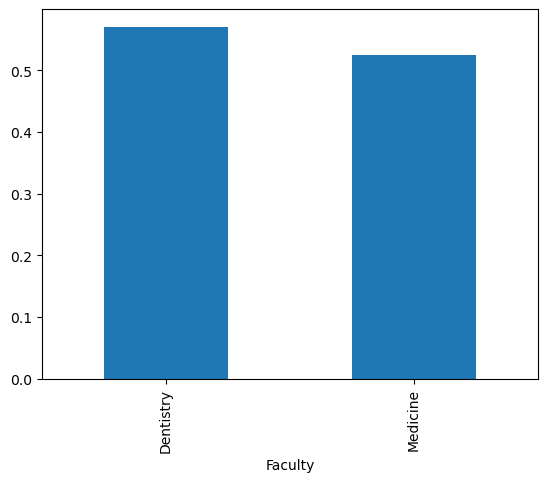

In [21]:
group_faculty.plot(kind="bar")

In [22]:
grouped = df.groupby(["Faculty", "Academic level"])["knowledge_score"].mean()
grouped

Faculty    Academic level
Dentistry  Fifth year        0.591049
           First year        0.413194
           Fourth year       0.696429
           Second year       0.474074
           Third year        0.555556
Medicine   Fifth year        0.581158
           First year        0.384058
           Fourth year       0.571581
           Second year       0.504831
           Third year        0.522690
Name: knowledge_score, dtype: float64

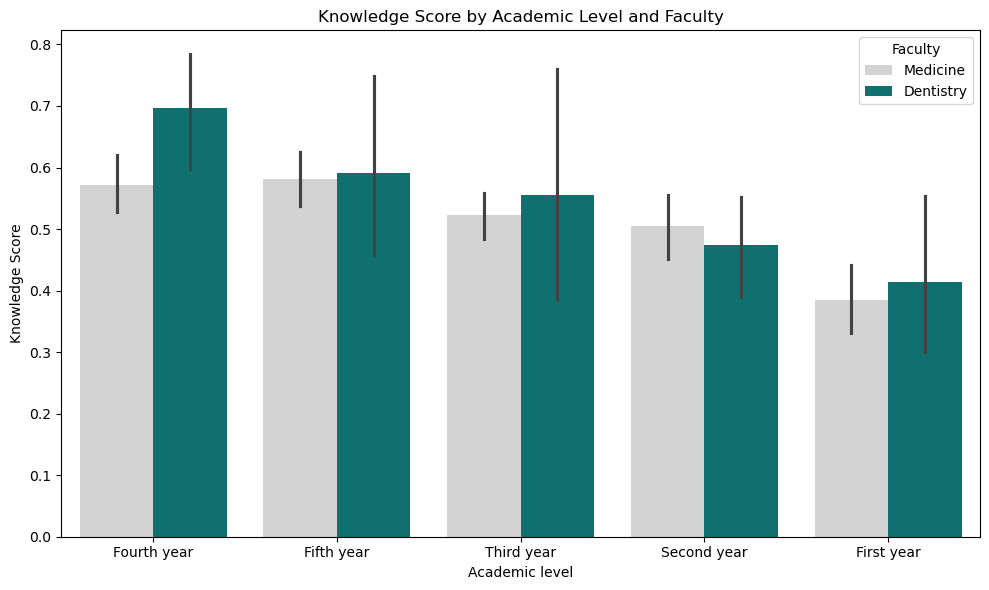

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign colors
palette = {"Dentistry": "teal", "Medicine": "lightgray"}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df, x="Academic level", y="knowledge_score", hue="Faculty", palette=palette
)

plt.title("Knowledge Score by Academic Level and Faculty")
plt.ylabel("Knowledge Score")
plt.tight_layout()
plt.show()

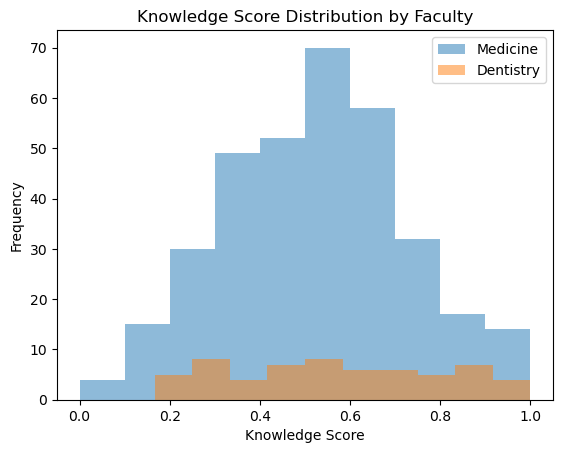

In [24]:
faculties = df["Faculty"].unique()

for faculty in faculties:
    subset = df[df["Faculty"] == faculty]
    plt.hist(subset["knowledge_score"], bins=10, alpha=0.5, label=faculty)

plt.legend()
plt.xlabel("Knowledge Score")
plt.ylabel("Frequency")
plt.title("Knowledge Score Distribution by Faculty")
plt.show()

Although the sample size of Dentistry students is relatively small, they still demonstrate higher levels of knowledge compared to Medical students. However, the observed difference in knowledge between the two groups is considered minimal.

The progression of improved knowledge while advancing through the academic levels is also evident although minimal.

In [25]:
df.describe()

,RecordID,Age,knowledge_score
count,401.000000,401.000000,401.000000
mean,204.256858,22.124688,0.531969
std,117.644428,2.453449,0.209500
min,0.000000,18.000000,0.000000
25%,103.000000,20.000000,0.375000
50%,205.000000,22.000000,0.541667
75%,305.000000,24.000000,0.666667
max,407.000000,35.000000,1.000000


In [26]:
np.median(df["knowledge_score"])

0.5416666666666666

In [27]:
np.var(df["knowledge_score"], ddof=1)

0.04389008910978722

## Descriptive Analytics for Score of Knowledge of Healthcare students
mean = 0.53

mode = 0.54

median = 0.54

std = 0.20

variance = 0.043 -> fairly clustered

{'whiskers': [<matplotlib.lines.Line2D at 0x17ed1e090>,
 'caps': [<matplotlib.lines.Line2D at 0x17ed1eed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x17ed1e600>],
 'medians': [<matplotlib.lines.Line2D at 0x17ed1f4d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17ed1f7a0>],
 'means': []}

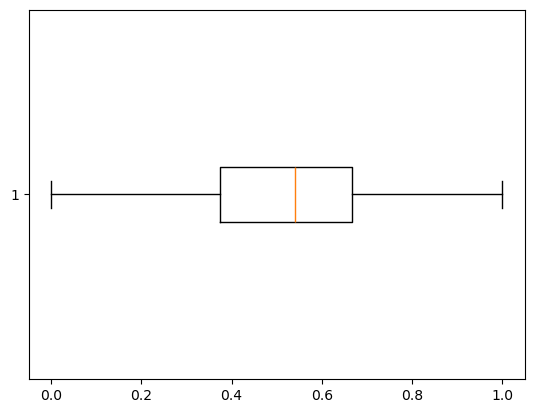

In [28]:
plt.boxplot(df["knowledge_score"], vert=False)

Let's calculate if there's any outliers

In [29]:
Q1 = df["knowledge_score"].quantile(0.25)
Q3 = df["knowledge_score"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[
    (df["knowledge_score"] < lower_bound) | (df["knowledge_score"] > upper_bound)
]
outliers  # No outliers found!

,RecordID,Timestamp,Are you a student at University of Gezira?,Age,Gender,Faculty,Academic level,Causes of dental caries,Causes of bleeding during tooth brushing:,Influence of dental plaque:,...,Systemic diseases that may be related to oral diseases:,Which is more important for oral health: self-administration or dentist?:,Frequency of daily tooth brushing.,Duration of tooth brushing.,Frequency of replacing tooth brush.,Frequency of visiting dentist.,Method of tooth brushing:,Oral hygiene methods besides tooth brushing:,What oral health problem(s) do you have (you can choose more than one):,knowledge_score


In [30]:
df_knowledge.head()

,RecordID,Faculty,Academic level,Q1,Q2,Q3,Q4,Q5,Q6,Q1_score,Q2_score,Q3_score,Q4_score,Q5_score,Q6_score
0,0,Medicine,Fourth year,"Toothpaste without fluoride, Frequent ingestio...",Brushing too hard,Affecting appearance,Application of fluoride,Heart diseases,Self-administration of oral hygiene,1.000000,0.333333,0.333333,0.333333,0.25,1.0
1,1,Medicine,Fifth year,Dynamic of oral micro-flora,Periodontal disease,Affecting appearance,Application of fluoride,Heart diseases,Self-administration of oral hygiene,0.333333,0.333333,0.333333,0.333333,0.25,1.0
2,2,Dentistry,Fourth year,"Frequent ingestion of sugar, Dynamic of oral m...","Natural physiological phenomenon, Brushing too...",Don't know,"Application of fluoride, Pit & fissure sealing","None of the above, Other diseases",Regular visit to dentist,1.000000,0.333333,0.000000,0.666667,0.25,0.0
3,3,Medicine,Fifth year,"Frequent ingestion of sugar, Inadequate tooth ...","Periodontal disease, Brushing too hard, System...","Affecting appearance, Inducing dental caries, ...","Application of fluoride, Tooth scaling","Heart diseases, Diabetes mellitus, Hypertension",Self-administration of oral hygiene,0.666667,1.000000,1.000000,0.666667,0.75,1.0
4,4,Medicine,Third year,"Frequent ingestion of sugar, Dynamic of oral m...","Brushing too hard, Systemic disease","Affecting appearance, Inducing dental caries",Application of fluoride,None of the above,Regular visit to dentist,1.000000,0.666667,0.666667,0.333333,0.00,0.0


In [31]:
df_knowledge_scores = df_knowledge[
    [
        "Faculty",
        "Academic level",
        "Q1_score",
        "Q2_score",
        "Q3_score",
        "Q4_score",
        "Q5_score",
        "Q6_score",
    ]
].copy()

In [32]:
import scipy.stats as stats


def compute_pvalues_ttest(df_long, group_col, value_col, question_col):
    pvals = {}
    for question_option in df_long[question_col].unique():
        data = df_long[df_long[question_col] == question_option]
        if isinstance(group_col, str):
            groups = [
                group[value_col].values for name, group in data.groupby(group_col)
            ]

            if len(groups) == 2:
                stat, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
            else:
                stat, p = stats.f_oneway(*groups)

            pvals[question_option] = p

        else:
            for first_group_val, subgroup in data.groupby(group_col[0]):
                # Create two groups based on the second grouping column
                groups = [
                    group[value_col].values
                    for name, group in subgroup.groupby(group_col[1])
                ]
                if len(groups) == 2:
                    stat, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
                else:
                    stat, p = stats.f_oneway(*groups)

                pvals[(question_option, first_group_val)] = p

    return pvals

In [33]:
df_long = df_knowledge_scores.melt(
    id_vars=["Faculty", "Academic level"],  # keep these columns as they are
    value_vars=[
        col for col in df_knowledge_scores.columns if col.startswith("Q")
    ],  # question columns
    var_name="Question",
    value_name="Score",
)

In [34]:
table = df_long.pivot_table(
    values="Score",
    index="Question",
    columns=["Academic level", "Faculty"],
    aggfunc=np.mean,
)
pvals = compute_pvalues_ttest(
    df_long,
    group_col=["Academic level", "Faculty"],
    value_col="Score",
    question_col="Question",
)
table_with_p_academic = final_table(table, pvals)
table_with_p_academic

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/3018156831.py:1: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = df_long.pivot_table(


Fifth year                     First year                      \
          Dentistry  Medicine   p-value  Dentistry  Medicine   p-value   
Question                                                                 
Q1_score   0.592593  0.638554  0.647958   0.500000  0.398551  0.341085   
Q2_score   0.740741  0.702811  0.742407   0.541667  0.434783  0.380293   
Q3_score   0.444444  0.465863  0.872114   0.458333  0.260870  0.126915   
Q4_score   0.740741  0.465863  0.018692   0.291667  0.340580  0.704530   
Q5_score   0.583333  0.418675  0.153559   0.187500  0.195652  0.910135   
Q6_score   0.444444  0.795181  0.084759   0.500000  0.673913  0.410425   

         Fourth year                     Second year                      \
           Dentistry  Medicine   p-value   Dentistry  Medicine   p-value   
Question                                                                   
Q1_score    0.777778  0.641026  0.052304    0.600000  0.659420  0.556698   
Q2_score    0.682540  0.661538  0.770655    0.688889  0.601449  0.215514   
Q3_score    0.682540  0.441026  0.007129    0.444444  0.253623  0.077761   
Q4_score    0.857143  0.482051  0.000002    0.444444  0.449275  0.948995   
Q5_score    0.511905  0.434615  0.238352    0.266667  0.239130  0.702014   
Q6_score    0.666667  0.769231  0.390844    0.400000  0.826087  0.007414   

         Third year                      
          Dentistry  Medicine   p-value  
Question                                 
Q1_score   0.476190  0.613861  0.314877  
Q2_score   0.571429  0.574257  0.984831  
Q3_score   0.571429  0.382838  0.234931  
Q4_score   0.571429  0.409241  0.147291  
Q5_score   0.428571  0.373762  0.664406  
Q6_score   0.714286  0.782178  0.730609

There's still great variability when you take in consideration sub-groups but this provide more meaningful information compared to comparing the proportions of selecting each question for the different questions that measure knowledge.

In [35]:
table = df_long.pivot_table(
    values="Score", index="Question", columns=["Faculty"], aggfunc=np.mean
)
pvals = compute_pvalues_ttest(
    df_long, group_col="Faculty", value_col="Score", question_col="Question"
)
table.columns.name = None
pvals_series = pd.Series(pvals, name="p-value")
table_with_p = table.join(pvals_series)
table_with_p["p-value"] = table_with_p["p-value"].apply(lambda x: f"{x:.4f}")
table_with_p

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/3116113009.py:1: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = df_long.pivot_table(


,Dentistry,Medicine,p-value
Question,,,
Q1_score,0.633333,0.602151,0.4699
Q2_score,0.661111,0.607038,0.1814
Q3_score,0.544444,0.380254,0.0013
Q4_score,0.627778,0.433040,0.0000
Q5_score,0.408333,0.354106,0.1749
Q6_score,0.550000,0.774194,0.0016


The p-values here have sufficient significance in order for us to reject the null hypothesis showing there's an actual difference between medical students and dental students which wasn't evident before using the chi-square test when comparing question options against each other.

Now I will compare between groups based on final knowledge score.

In [36]:
df.head()

,RecordID,Timestamp,Are you a student at University of Gezira?,Age,Gender,Faculty,Academic level,Causes of dental caries,Causes of bleeding during tooth brushing:,Influence of dental plaque:,...,Systemic diseases that may be related to oral diseases:,Which is more important for oral health: self-administration or dentist?:,Frequency of daily tooth brushing.,Duration of tooth brushing.,Frequency of replacing tooth brush.,Frequency of visiting dentist.,Method of tooth brushing:,Oral hygiene methods besides tooth brushing:,What oral health problem(s) do you have (you can choose more than one):,knowledge_score
0,0,9/24/2023 22:01:24,Yes,23.0,Male,Medicine,Fourth year,"Toothpaste without fluoride, Frequent ingestio...",Brushing too hard,Affecting appearance,...,Heart diseases,Self-administration of oral hygiene,1,2 to 3 minutes,Every three months,When I have a dental problem/oral disease,Irregular,Mouthwash,Abnormal growth of last molar in the left side...,0.541667
1,1,9/24/2023 22:04:16,Yes,25.0,Male,Medicine,Fifth year,Dynamic of oral micro-flora,Periodontal disease,Affecting appearance,...,Heart diseases,Self-administration of oral hygiene,2,More than 3 minutes,Every three months,Twice a year,Horizontal scrub,Mouthwash,Dental caries,0.430556
2,2,9/24/2023 22:05:24,Yes,24.0,Male,Dentistry,Fourth year,"Frequent ingestion of sugar, Dynamic of oral m...","Natural physiological phenomenon, Brushing too...",Don't know,...,"None of the above, Other diseases",Regular visit to dentist,2,2 to 3 minutes,Every three months,Twice a year,Modified pass technique,Toothpick,No problem,0.375000
3,3,9/24/2023 22:09:19,Yes,25.0,Male,Medicine,Fifth year,"Frequent ingestion of sugar, Inadequate tooth ...","Periodontal disease, Brushing too hard, System...","Affecting appearance, Inducing dental caries, ...",...,"Heart diseases, Diabetes mellitus, Hypertension",Self-administration of oral hygiene,1,More than 3 minutes,Every three months,Once a year,Vertical scrub,Mouthwash,Toothache,0.847222
4,4,9/24/2023 22:09:26,Yes,20.0,Male,Medicine,Third year,"Frequent ingestion of sugar, Dynamic of oral m...","Brushing too hard, Systemic disease","Affecting appearance, Inducing dental caries",...,None of the above,Regular visit to dentist,1,2 to 3 minutes,Until it can't be used,When I have a dental problem/oral disease,Horizontal scrub,Sugar-free chewing gum,Toothache,0.444444


In [37]:
pvals = {}
for level, subgroup in df.groupby("Academic level"):
    # Create two groups based on the second grouping column
    groups = [
        group["knowledge_score"].values for name, group in subgroup.groupby("Faculty")
    ]
    _, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
    pvals[level] = p


table = df.pivot_table(
    values="knowledge_score",
    index=[],
    columns=["Academic level", "Faculty"],
    aggfunc=np.mean,
)

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/1137653939.py:11: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  table = df.pivot_table(


In [38]:
pval_df = pd.DataFrame(index=table.index)

# For each academic level, create a p-value column with NaNs (or p-value repeated)
for level in pvals:
    # Create a MultiIndex column with (level, 'p-value')
    col = pd.MultiIndex.from_tuples([(level, "p-value")])
    # Create a Series with the p-value repeated for all rows (likely just one row)
    pval_series = pd.Series([pvals[level]] * len(table), index=table.index)
    # Assign to DataFrame
    pval_df[col] = pval_series

# Now concatenate along columns
combined = pd.concat([table, pval_df], axis=1)

new_cols = []

for level in sorted(table.columns.levels[0]):  # iterate academic levels in order
    # faculty columns for this level
    faculties = [col for col in table.columns if col[0] == level]
    new_cols.extend(faculties)
    # add p-value column for this level
    new_cols.append((level, "p-value"))

combined = combined[new_cols]

combined

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval_df[col] = pval_series
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval_df[col] = pval_series
/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/3682480166.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Fifth year                     First year                      \
                 Dentistry  Medicine   p-value  Dentistry  Medicine   p-value   
knowledge_score   0.591049  0.581158  0.907965   0.413194  0.384058  0.711948   

                Fourth year                     Second year            \
                  Dentistry  Medicine   p-value   Dentistry  Medicine   
knowledge_score    0.696429  0.571581  0.030411    0.474074  0.504831   

                          Third year                     
                  p-value  Dentistry Medicine   p-value  
knowledge_score  0.551572   0.555556  0.52269  0.776311

Apparently due to sampling you can't reject that there's no difference between academic levels

In [39]:
groups = [group["knowledge_score"].values for name, group in df.groupby("Faculty")]
_, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
pivot_scores = df.pivot_table(
    index=[],  # no index, we want a single row
    columns="Faculty",
    values="knowledge_score",
    aggfunc=np.mean,
).reset_index(drop=True)
pivot_scores["p-value"] = p
pivot_scores

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/4115794660.py:3: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_scores = df.pivot_table(


Faculty,Dentistry,Medicine,p-value
0,0.570833,0.52513,0.165486


Significance is very evident now when samples are combined to be quite large!

In [40]:
groups = [group["knowledge_score"].values for name, group in df.groupby("Gender")]
_, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
pivot_scores = df.pivot_table(
    index=[], columns="Gender", values="knowledge_score", aggfunc=np.mean
).reset_index(drop=True)
pivot_scores["p-value"] = p
pivot_scores

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_7307/1239801507.py:3: FutureWarning: The provided callable <function mean at 0x104c10c20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_scores = df.pivot_table(


Gender,Female,Male,p-value
0,0.529139,0.541082,0.631558
